# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [146]:
#import the necessary packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [147]:
#read the dataset 
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [148]:
#display the number of rows
total_count = df.shape[0]
total_count

294478

c. The number of unique users in the dataset.

In [149]:
#display the number of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [150]:
#display the proportion of users converted
df.query('converted == 1').user_id.count() / df.user_id.nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [151]:
#display the count of how many times new page and treatment group doesn't match
df[((df['group'] == "treatment") & (df['landing_page'] != "new_page"))].user_id.count()

1965

f. Do any of the rows have missing values?

In [152]:
#check whether any rows have null values
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [153]:
#df2 = df[((df['group'] == "control") & (df['landing_page'] != "new_page")|((df['group'] == "treatment") & (df['landing_page'] == "old_page"))|((df['group'] == "control") & (df['landing_page'] == "new_page"))]
#dataframe = df[(((df['group'] == "treatment") & (df['landing_page'] != "new_page"))|((df['group'] != "treatment") & (df['landing_page'] == "new_page")) | ((df['group'] == "control") & (df['landing_page'] != "old_page"))|((df['group'] != "control") & (df['landing_page'] == "old_page")))]
#dataframe.count()
#df2 = dataframe

In [154]:
#create a dataframe for new page and treatment group
df2_treatment = df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]

In [155]:
#create a dataframe for old page and control group
df2_control = df[(df['group'] == 'control') & (df['landing_page'] == 'old_page')]

In [156]:
#merge both the dataframes
df2 = pd.merge(df2_treatment, df2_control, how = 'outer')
df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

In [157]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [158]:
#display the number of unique user id
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [159]:
#display the duplicated user id
df2[df2.duplicated(['user_id'])].user_id

1404    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [160]:
#display the duplicated record
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [161]:
#remove the duplicate record
df2 = df2[~df2.duplicated(['user_id'], keep='first')]

In [162]:
#Checking the shape after dropping the duplicated record
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [163]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [164]:
converting_ind = df2[df2['converted']==1]
ratio = converting_ind.user_id.count() / df2.user_id.count()
ratio

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [165]:
control_group = df2[df2['group'] == 'control']
control_group.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [166]:
treatment_group = df2[df2['group'] == 'treatment']
treatment_group.converted.mean()

0.11880806551510564

In [167]:
#actual difference in the dataset
d = treatment_group.converted.mean() - control_group.converted.mean()
d

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [168]:
#probability of getting a new page
new_page = df2.query('landing_page == "new_page"').landing_page.count()
new_page/df2.landing_page.count()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

It appears that individuals in the treatment group had a conversion rate of 11.88% and individuals in the control grounp had a conversion rate of 12.04%. This leads us to think that the treatment group does not lead to more conversions than the treatment group. However, it remains to be seen if this is true, or due to some bias.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$ : $p_{old}$ >=  $p_{new}$
$H_{1}$ : $p_{old}$ <  $p_{new}$



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [169]:
#conversion rate for new page
p_new = df2['converted'].mean()
print(p_new)

0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [170]:
#conversion rate for old page
p_old = df2['converted'].mean()
print(p_old)

0.119597087245


c. What is $n_{new}$, the number of individuals in the treatment group?

In [171]:
#number of unique users in treatment group
n_new = treatment_group.user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [172]:
#number of unique users in control group
n_old = control_group.user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [173]:
#Simulation for new page conversion
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, 1-p_new])
print(new_page_converted)

[0 0 0 ..., 1 0 0]


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [174]:
#simulations for old page conversion
old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old, 1-p_old])
print(old_page_converted)

[0 0 0 ..., 0 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [175]:
#truncate the new column so as to match with the size of old page conversion rate
new_page_converted = new_page_converted[:145274]

In [176]:
#find the difference between new and old page conversion rate
p_diff = (new_page_converted.mean()) - (old_page_converted.mean())
print(p_diff)

-0.000798491127112


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [177]:
#specifying size as n_old since the n_old size is smaller when compared to n_new
#p_diffs = []
#for _ in range(10000):
#    new_page = np.random.choice([1,0], size = n_old, p = [p_new, 1-p_new]).mean()
#    old_page = np.random.choice([1,0], size = n_old, p = [p_old, 1-p_old]).mean()
#    p_diffs.append(new_page - old_page)

In [178]:
#simulation of mean difference
p_diffs = []
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted-old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

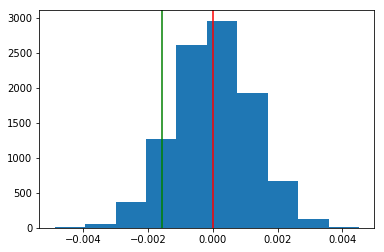

In [179]:
#plot histogram for the actual vs simulated values
plt.hist(p_diffs)
plt.axvline(d, color='green', label = 'mean of ab_data difference')
plt.axvline(p_diffs.mean(), color='red', label = 'mean of null difference')

In [180]:
#check the difference of mean in simulated one
p_diffs.mean()

1.9952833989254265e-05

In [181]:
#check the actual mean difference
d

-0.0015782389853555567

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [182]:
#compute p-value
(p_diffs > d).mean()

0.90869999999999995

In [183]:
(p_diffs < d).mean()

0.091300000000000006

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv is called the p-value

A p-value is the probability of observing your statistic if the null hypothesis is true.

The null hypothesis was that the difference in means would be equal or less than 0, and the alternative was the difference would be greater than 0. However, the difference is less than zero, and the p-value is very large. We do not have evidence to reject the null.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [184]:
#import package used for logistic regression
import statsmodels.api as sm

convert_old = len(df2_control[df2_control['converted'] == 1])
convert_new = len(df2_treatment[df2_treatment['converted'] == 1])
n_old = len(df2_control.index)
n_new = len(df2_treatment.index)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [185]:
#compute p value and z score
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

 In statistics, the standard score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

Before this test began, we would have picked a significance level. Let's just say it's 95%. Since this is a test for the difference, it's a two-tail test so a z-score past -1.96 or 1.96 will be significant. 

The conversion rate of the new landing page is only 1.3116 standard deviations from the conversion rate of the old landing page. This is less than the critical value of 1.96. We cannot reject the hull hypothesis that the difference between the two conversion rates is no different from zero.

Also, the p-value is 0.9052. The p-value was calculated where the null hypothesis was that the new page would convert more than the old page, and the alternative was the old page converted more than or equal to the new page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [186]:
#creating intercept column and dummy columns for group column
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop(['control'],axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [187]:
#fitting the logistic model
import statsmodels.api as sm
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [188]:
#summarizing the result
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:00:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value here suggests that that new page is not statistically significant as 0.19 > 0.05. The values are different because in part 2 we randomly sampled the data 10000 times and the sample could have overlapped or been mutually exclusive to an extent to give different values such that differet p-values were received than what we got in logistic regression.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Considering other factors/explanatory variables makes our hypothesis results more reliable as it can improve the r-sqaured values plus we might miss other influencing factors of out response variables. But if multicolinearity exists, that is correlation between explanatory variables then our results will be wrong. So we need to make sure that there is no multicolinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [189]:
#reading countries.csv and join the dataframe with the existing dataframe df2
country_df = pd.read_csv('countries.csv')
df_new = country_df.set_index('user_id').join(df2.set_index('user_id'), how='inner') #Merging 2 data frames with index as user_id
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [190]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [191]:
#fit the logistic model with countries
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 30 Aug 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:00:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [192]:
#fit the logistic model
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US', 'ab_page']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 30 Aug 2019   Pseudo R-squ.:               2.323e-05
Time:                        18:00:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

In [193]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results.ipynb'])

0